# Congressional Record and Hansard Word Embeddings Analysis


## Setup


In [3]:
import os
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
from tqdm import tqdm
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from scipy.stats import ttest_rel

DATA_PATH = 'data/'
DIST_PATH = 'dist/'

EMBEDDINGS_PATH = '../../glove-embeddings/'

if not os.path.exists(DIST_PATH):
    os.makedirs(DIST_PATH)

tqdm.pandas()
plt.style.use('ggplot')

/Users/felixwallis/Desktop/UCL Politics and International Relations Course/Dissertation.nosync/pir-dissertation/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Generating word embeddings


### Functions for GloVe embeddings


In [2]:
word_vectors = KeyedVectors.load_word2vec_format(
    f'{EMBEDDINGS_PATH}glove.840B.300d.txt', binary=False, no_header=True)

In [5]:
def get_weighted_embedding(doc, tokens_column, word_vectors, tfidf_matrix, feature_names):
    doc_tokens = doc[tokens_column].split()
    doc_embedding = np.zeros(word_vectors.vector_size)

    # Get the document index in the TF-IDF matrix
    doc_index = doc.name

    # Get the column indices and values for the current document in the TF-IDF matrix
    col_indices = tfidf_matrix[doc_index].indices
    tfidf_scores = tfidf_matrix[doc_index].data

    # Create a dictionary of token to TF-IDF score for the current document
    tfidf_dict = {feature_names[col_index]: score for col_index, score in zip(
        col_indices, tfidf_scores)}

    # Calculate the weighted embedding by summing the product of word vectors and TF-IDF scores
    weighted_vectors = [word_vectors[token] * tfidf_dict.get(
        token, 0) for token in doc_tokens if token in word_vectors.key_to_index]
    if weighted_vectors:
        doc_embedding = sum(weighted_vectors)

    # Normalize by dividing by the number of words in the sentence
    if len(doc_tokens) > 0:
        doc_embedding /= len(doc_tokens)

    return doc_embedding


def generate_weighted_embeddings(corpus_df, tokens_column, word_vectors):
    # Create a TF-IDF vectorizer and calculate the TF-IDF matrix
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(corpus_df[tokens_column])

    # Convert the TF-IDF matrix to a compressed sparse row matrix for efficient row-wise access
    tfidf_matrix_csr = csr_matrix(tfidf_matrix)

    # Get the feature names (tokens) from the vectorizer
    feature_names = tfidf_vectorizer.get_feature_names_out()

    tqdm.pandas(desc="Generating weighted embeddings")
    corpus_df['weighted_embedding'] = corpus_df.progress_apply(
        lambda doc: get_weighted_embedding(
            doc, tokens_column, word_vectors, tfidf_matrix_csr, feature_names),
        axis=1
    )

    return corpus_df

### Embedding the Congressional Record and Hansard


**Embedding the Congressional Record**


In [8]:
congressional_record = pd.read_csv(
    DATA_PATH + 'non_procedural_congressional_record.csv')

congressional_record_embeddings = generate_weighted_embeddings(
    congressional_record, 'cleaned_tokens', word_vectors)

congressional_record_embeddings.to_parquet(
    DATA_PATH + 'congressional_record_embeddings.parquet')

del congressional_record
del congressional_record_embeddings

Generating weighted embeddings: 100%|██████████| 478172/478172 [03:03<00:00, 2606.02it/s]


**Embedding Hansard**


In [10]:
hansard = pd.read_csv(DATA_PATH + 'non_procedural_hansard.csv')

hansard_embeddings = generate_weighted_embeddings(
    hansard, 'cleaned_tokens', word_vectors)

hansard_embeddings.to_parquet(DATA_PATH + 'hansard_embeddings.parquet')

del hansard
del hansard_embeddings

Generating weighted embeddings: 100%|██████████| 448828/448828 [01:03<00:00, 7037.35it/s] 


### Embedding the Climate Congressional Record and Climate Hansard


**Embedding the Climate Congressional Record**


In [6]:
climate_congressional_record = pd.read_csv(
    DATA_PATH + 'climate_congressional_record.csv')

climate_congressional_record_embeddings = generate_weighted_embeddings(
    climate_congressional_record, 'cleaned_tokens', word_vectors)

climate_congressional_record_embeddings.to_parquet(
    DATA_PATH + 'climate_congressional_record_embeddings.parquet')

del climate_congressional_record
del climate_congressional_record_embeddings

Generating weighted embeddings: 100%|██████████| 27043/27043 [00:08<00:00, 3094.82it/s]


**Embedding Climate Hansard**


In [7]:
climate_hansard = pd.read_csv(DATA_PATH + 'climate_hansard.csv')

climate_hansard_embeddings = generate_weighted_embeddings(
    climate_hansard, 'cleaned_tokens', word_vectors)

climate_hansard_embeddings.to_parquet(
    DATA_PATH + 'climate_hansard_embeddings.parquet')

del climate_hansard
del climate_hansard_embeddings

Generating weighted embeddings: 100%|██████████| 25510/25510 [00:03<00:00, 8361.25it/s]


## Cluster analysis


In [3]:
congressional_record_embeddings = pd.read_parquet(
    DATA_PATH + 'congressional_record_embeddings.parquet')
hansard_embeddings = pd.read_parquet(DATA_PATH + 'hansard_embeddings.parquet')

climate_congressional_record_embeddings = pd.read_parquet(
    DATA_PATH + 'climate_congressional_record_embeddings.parquet')
climate_hansard_embeddings = pd.read_parquet(
    DATA_PATH + 'climate_hansard_embeddings.parquet')

### Visualising the embeddings


**Transforming the embeddings to 3D with UMAP**


In [20]:
umap_model = umap.UMAP(n_neighbors=15, n_components=5, metric='cosine')

embeddings_dfs = [(congressional_record_embeddings, 'congressional_record_embeddings'),
                  (hansard_embeddings, 'hansard_embeddings'),
                  (climate_congressional_record_embeddings,
                   'climate_congressional_record_embeddings'),
                  (climate_hansard_embeddings, 'climate_hansard_embeddings')]

for embeddings_df, name in tqdm(embeddings_dfs, desc="Generating UMAP embeddings"):
    embeddings = embeddings_df['weighted_embedding'].to_list()
    umap_embeddings = umap_model.fit_transform(embeddings)
    embeddings_df['umap_embedding'] = umap_embeddings.tolist()

    embeddings_df.to_parquet(DATA_PATH + f'{name}.parquet', index=False)

Generating UMAP embeddings: 100%|██████████| 4/4 [08:18<00:00, 124.61s/it]


**Plotting Climate Congressional Record and Climate Hansard embeddings**


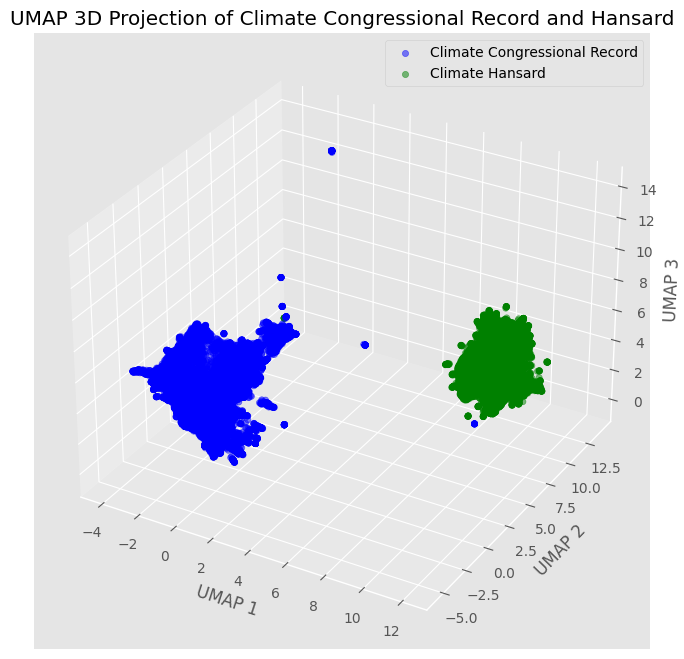

In [21]:
climate_congressional_record_embeddings = pd.read_parquet(
    DATA_PATH + 'climate_congressional_record_embeddings.parquet')
climate_hansard_embeddings = pd.read_parquet(
    DATA_PATH + 'climate_hansard_embeddings.parquet')

umap_climate_congressional_record_embeddings = np.array(
    climate_congressional_record_embeddings['umap_embedding'].to_list())
umap_climate_hansard_embeddings = np.array(
    climate_hansard_embeddings['umap_embedding'].to_list())

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    umap_climate_congressional_record_embeddings[:, 0],
    umap_climate_congressional_record_embeddings[:, 1],
    umap_climate_congressional_record_embeddings[:, 2],
    label='Climate Congressional Record',
    color='blue',
    alpha=0.5
)

ax.scatter(
    umap_climate_hansard_embeddings[:, 0],
    umap_climate_hansard_embeddings[:, 1],
    umap_climate_hansard_embeddings[:, 2],
    label='Climate Hansard',
    color='green',
    alpha=0.5
)

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')
ax.set_title('UMAP 3D Projection of Climate Congressional Record and Hansard')
ax.legend()
plt.show()

**Plotting Congressional Record and Hansard embeddings**


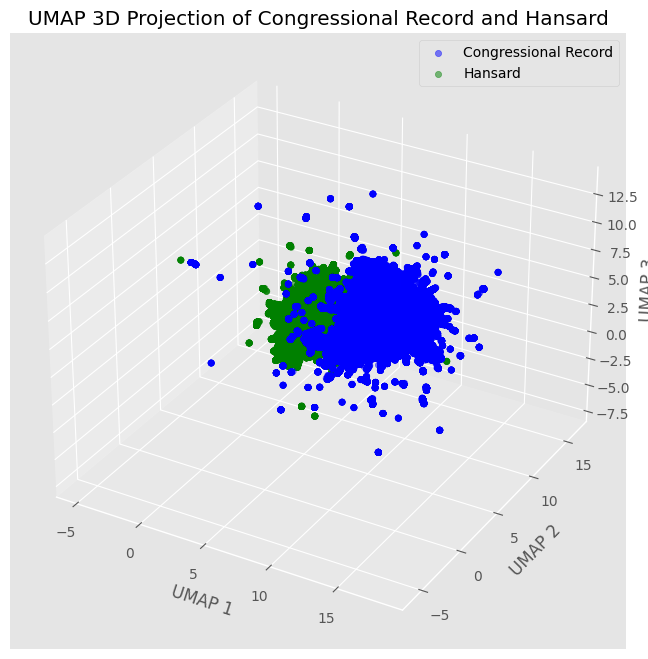

In [38]:
congressional_record_embeddings = pd.read_parquet(
    DATA_PATH + 'congressional_record_embeddings.parquet')
hansard_embeddings = pd.read_parquet(DATA_PATH + 'hansard_embeddings.parquet')

umap_congressional_record_embeddings = np.array(
    congressional_record_embeddings['umap_embedding'].to_list())
umap_hansard_embeddings = np.array(
    hansard_embeddings['umap_embedding'].to_list())

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    umap_congressional_record_embeddings[:, 0],
    umap_congressional_record_embeddings[:, 1],
    umap_congressional_record_embeddings[:, 2],
    label='Congressional Record',
    color='blue',
    alpha=0.5
)

ax.scatter(
    umap_hansard_embeddings[:, 0],
    umap_hansard_embeddings[:, 1],
    umap_hansard_embeddings[:, 2],
    label='Hansard',
    color='green',
    alpha=0.5
)

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')
ax.set_title('UMAP 3D Projection of Congressional Record and Hansard')

ax.legend()
plt.show()

### Calculating Silhouette scores for the embeddings


**Functions**


In [17]:
def create_embeddings_dataframe(embeddings, country, column_name):
    df = pd.DataFrame(embeddings, columns=[column_name])
    df['country'] = country
    return df


def calculate_silhouette_score(embeddings, column_name, metric):
    score = metrics.silhouette_score(
        embeddings[column_name].to_list(), labels=embeddings['country'], metric=metric)
    return score

**Climate embeddings silhouette scores**


In [18]:
us_embeddings = create_embeddings_dataframe(
    climate_congressional_record_embeddings, 'US', 'weighted_embedding')
uk_embeddings = create_embeddings_dataframe(
    climate_hansard_embeddings, 'UK', 'weighted_embedding')
us_umap_embeddings = create_embeddings_dataframe(
    climate_congressional_record_embeddings, 'US', 'umap_embedding')
uk_umap_embeddings = create_embeddings_dataframe(
    climate_hansard_embeddings, 'UK', 'umap_embedding')

combined_embeddings = pd.concat(
    [us_embeddings, uk_embeddings], ignore_index=True)
combined_umap_embeddings = pd.concat(
    [us_umap_embeddings, uk_umap_embeddings], ignore_index=True)

silhouette_score = calculate_silhouette_score(
    combined_embeddings, 'weighted_embedding', 'cosine')
umap_silhouette_score = calculate_silhouette_score(
    combined_umap_embeddings, 'umap_embedding', 'cosine')

print(f'Silhouette Score: {silhouette_score}')
print(f'UMAP Silhouette Score: {umap_silhouette_score}')

Silhouette Score: 0.02336893044412136
UMAP Silhouette Score: 0.940399826543874


**Complete embeddings silhouette scores**


In [19]:
us_weighted_embeddings = create_embeddings_dataframe(
    congressional_record_embeddings, 'US', 'weighted_embedding')
uk_weighted_embeddings = create_embeddings_dataframe(
    hansard_embeddings, 'UK', 'weighted_embedding')
us_umap_embeddings = create_embeddings_dataframe(
    congressional_record_embeddings, 'US', 'umap_embedding')
uk_umap_embeddings = create_embeddings_dataframe(
    hansard_embeddings, 'UK', 'umap_embedding')

combined_weighted_embeddings = pd.concat(
    [us_weighted_embeddings, uk_weighted_embeddings], ignore_index=True)
combined_umap_embeddings = pd.concat(
    [us_umap_embeddings, uk_umap_embeddings], ignore_index=True)

sample_size = int(0.1 * len(combined_weighted_embeddings))
sampled_weighted_embeddings = combined_weighted_embeddings.sample(
    sample_size, random_state=42)
sampled_umap_embeddings = combined_umap_embeddings.sample(
    sample_size, random_state=42)

weighted_silhouette_score = metrics.silhouette_score(
    sampled_weighted_embeddings['weighted_embedding'].to_list(), labels=sampled_weighted_embeddings['country'], metric='cosine')
umap_silhouette_score = metrics.silhouette_score(
    sampled_umap_embeddings['umap_embedding'].to_list(), labels=sampled_umap_embeddings['country'], metric='euclidean')

print(f'Weighted Silhouette Score: {weighted_silhouette_score}')
print(f'UMAP Silhouette Score: {umap_silhouette_score}')

Weighted Silhouette Score: 0.02452160231769085
UMAP Silhouette Score: 0.1704367019690591


## Time series analysis


In [6]:
congressional_record_embeddings = pd.read_parquet(
    DATA_PATH + 'congressional_record_embeddings.parquet')
hansard_embeddings = pd.read_parquet(DATA_PATH + 'hansard_embeddings.parquet')

climate_congressional_record_embeddings = pd.read_parquet(
    DATA_PATH + 'climate_congressional_record_embeddings.parquet')
climate_hansard_embeddings = pd.read_parquet(
    DATA_PATH + 'climate_hansard_embeddings.parquet')

### Calculating the monthly average cosine similarities for the full embeddings and climate embeddings


**Functions**


In [7]:
def process_month(group, party_1, party_2, party_column, prefix):
    party_1_group = group[group[party_column] ==
                          party_1]['weighted_embedding'].tolist()
    party_2_group = group[group[party_column] ==
                          party_2]['weighted_embedding'].tolist()

    if not party_1_group or not party_2_group:
        return pd.Series({
            f'{prefix}_num_speeches': 0,
            f'{prefix}_num_comparisons': 0,
            f'{prefix}_average_similarity': np.nan,
            f'{prefix}_std_dev_similarity': np.nan,
            f'{prefix}_std_err_similarity': np.nan,
            f'{prefix}_confidence_interval': np.nan,
            f'{prefix}_upper_bound': np.nan,
            f'{prefix}_lower_bound': np.nan
        })

    similarity_matrix = cosine_similarity(party_1_group, party_2_group)
    num_comparisons = similarity_matrix.size
    average_similarity = np.mean(similarity_matrix)
    std_dev_similarity = np.std(similarity_matrix)
    std_err_similarity = std_dev_similarity / np.sqrt(num_comparisons)
    confidence_interval = 1.96 * std_err_similarity

    return pd.Series({
        f'{prefix}_num_speeches': group.shape[0],
        f'{prefix}_num_comparisons': num_comparisons,
        f'{prefix}_average_similarity': average_similarity,
        f'{prefix}_std_dev_similarity': std_dev_similarity,
        f'{prefix}_std_err_similarity': std_err_similarity,
        f'{prefix}_confidence_interval': confidence_interval,
        f'{prefix}_upper_bound': average_similarity + confidence_interval,
        f'{prefix}_lower_bound': average_similarity - confidence_interval
    })


def prepare_and_process_data(embeddings, date_column, party_column, party_1, party_2, prefix):
    embeddings['year_month'] = pd.to_datetime(
        embeddings[date_column]).dt.to_period('M')
    embeddings.sort_values('year_month', inplace=True)

    similarities = embeddings.groupby('year_month').progress_apply(
        lambda month_group: process_month(
            month_group, party_1, party_2, party_column, prefix)
    )
    # Only return months with more than 20 speeches to avoid unreliable similarity estimates
    return similarities[similarities[f'{prefix}_num_speeches'] > 20]


def calculate_differences_and_significance(data_1, data_2, key_1, key_2):
    all_dates = pd.date_range(
        start=min(data_1.index.min(), data_2.index.min()).to_timestamp(),
        end=max(data_1.index.max(), data_2.index.max()).to_timestamp(),
        freq='M'
    ).to_period('M')

    monthly_similarities = pd.DataFrame(index=all_dates)
    monthly_similarities = monthly_similarities.join(data_1)
    monthly_similarities = monthly_similarities.join(data_2)

    monthly_similarities['difference_in_means'] = (
        monthly_similarities[f'{key_2}_average_similarity'] -
        monthly_similarities[f'{key_1}_average_similarity']
    )
    monthly_similarities['SE_diff'] = np.sqrt(
        monthly_similarities[f'{key_2}_std_err_similarity']**2 +
        monthly_similarities[f'{key_1}_std_err_similarity']**2
    )
    monthly_similarities['combined_confidence_interval'] = 1.96 * \
        monthly_similarities['SE_diff']
    monthly_similarities['upper_bound_diff'] = monthly_similarities['difference_in_means'] + \
        monthly_similarities['combined_confidence_interval']
    monthly_similarities['lower_bound_diff'] = monthly_similarities['difference_in_means'] - \
        monthly_similarities['combined_confidence_interval']
    monthly_similarities['significant_positive_diff'] = monthly_similarities['lower_bound_diff'] > 0
    monthly_similarities['significant_negative_diff'] = monthly_similarities['upper_bound_diff'] < 0

    return monthly_similarities

**Calculating monthly average cosine similarities for climate corpora**


In [26]:
cliamte_congressional_record_similarities = prepare_and_process_data(
    climate_congressional_record_embeddings, 'date', 'party', 'R', 'D', 'climate_congressional_record')
climate_hansard_similarities = prepare_and_process_data(
    climate_hansard_embeddings, 'speech_date', 'speech_party', 'Conservative', 'Labour', 'climate_hansard')

climate_monthly_similarities = calculate_differences_and_significance(
    cliamte_congressional_record_similarities, climate_hansard_similarities, 'climate_congressional_record', 'climate_hansard')

climate_monthly_similarities['year_month'] = climate_monthly_similarities.index

climate_monthly_similarities.to_csv(
    DATA_PATH + 'climate_monthly_similarities.csv', index=False)

100%|██████████| 199/199 [00:00<00:00, 326.31it/s]


**Calculating monthly average cosine similarities for full corpora**


In [33]:
congressional_record_similarities = prepare_and_process_data(
    congressional_record_embeddings, 'date', 'party', 'R', 'D', 'congressional_record')
hansard_similarities = prepare_and_process_data(
    hansard_embeddings, 'speech_date', 'speech_party', 'Conservative', 'Labour', 'hansard')

monthly_similarities = calculate_differences_and_significance(
    congressional_record_similarities, hansard_similarities, 'congressional_record', 'hansard')

monthly_similarities['year_month'] = monthly_similarities.index

monthly_similarities.to_csv(
    DATA_PATH + 'monthly_similarities.csv', index=False)

100%|██████████| 201/201 [00:03<00:00, 50.75it/s]


### Plotting the monthly average cosine similarities of the full embeddings and climate embeddings


**Climate embeddings monthly average cosine similarities**


/var/folders/g4/5xzy77v17m1fbt0xq_sn3f140000gn/T/ipykernel_61105/1492171756.py:8: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  interpolated_climate_monthly_similarities = climate_monthly_similarities.interpolate(


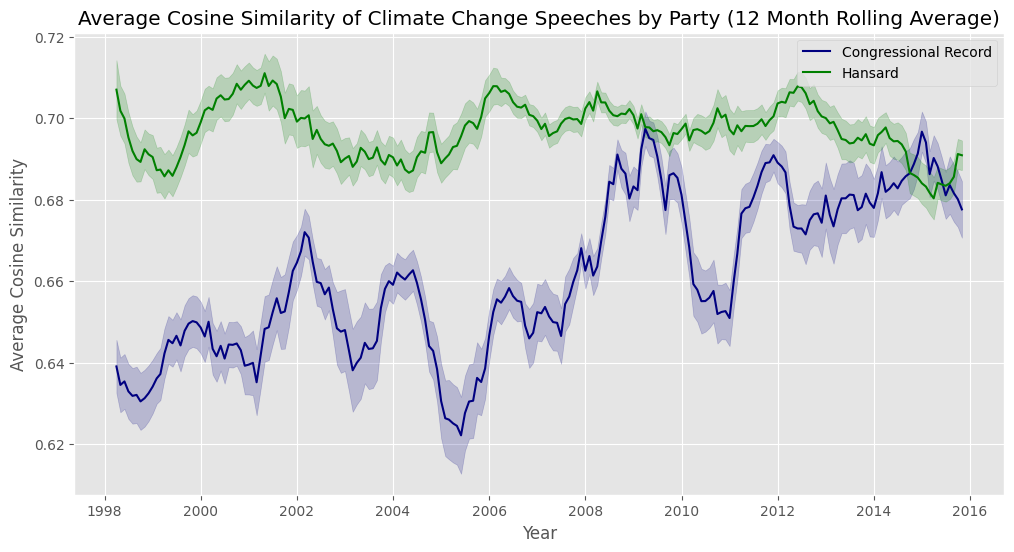

In [44]:
climate_monthly_similarities = pd.read_csv(
    DATA_PATH + 'climate_monthly_similarities.csv')

climate_monthly_similarities.index = pd.PeriodIndex(
    climate_monthly_similarities['year_month'], freq='M')

# Interpolate missing values for plotting
interpolated_climate_monthly_similarities = climate_monthly_similarities.interpolate(
    method='time').dropna()

# Window for rolling average
widow = 12

plt.figure(figsize=(12, 6))
plt.plot(interpolated_climate_monthly_similarities.index.to_timestamp(), interpolated_climate_monthly_similarities['climate_congressional_record_average_similarity'].rolling(
    window=widow).mean(), label='Congressional Record', color='navy')
plt.fill_between(interpolated_climate_monthly_similarities.index.to_timestamp(), interpolated_climate_monthly_similarities['climate_congressional_record_lower_bound'].rolling(
    window=widow).mean(), interpolated_climate_monthly_similarities['climate_congressional_record_upper_bound'].rolling(window=widow).mean(), alpha=0.2, color='navy')

plt.plot(interpolated_climate_monthly_similarities.index.to_timestamp(), interpolated_climate_monthly_similarities['climate_hansard_average_similarity'].rolling(
    window=widow).mean(), label='Hansard', color='green')
plt.fill_between(interpolated_climate_monthly_similarities.index.to_timestamp(), interpolated_climate_monthly_similarities['climate_hansard_lower_bound'].rolling(
    window=widow).mean(), interpolated_climate_monthly_similarities['climate_hansard_upper_bound'].rolling(window=widow).mean(), alpha=0.2, color='green')

plt.title('Average Cosine Similarity of Climate Change Speeches by Party (12 Month Rolling Average)')
plt.xlabel('Year')
plt.ylabel('Average Cosine Similarity')
plt.legend()

**Climate embeddings difference in means**


/var/folders/g4/5xzy77v17m1fbt0xq_sn3f140000gn/T/ipykernel_61105/852949640.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  interpolated_climate_monthly_similarities = climate_monthly_similarities.interpolate(


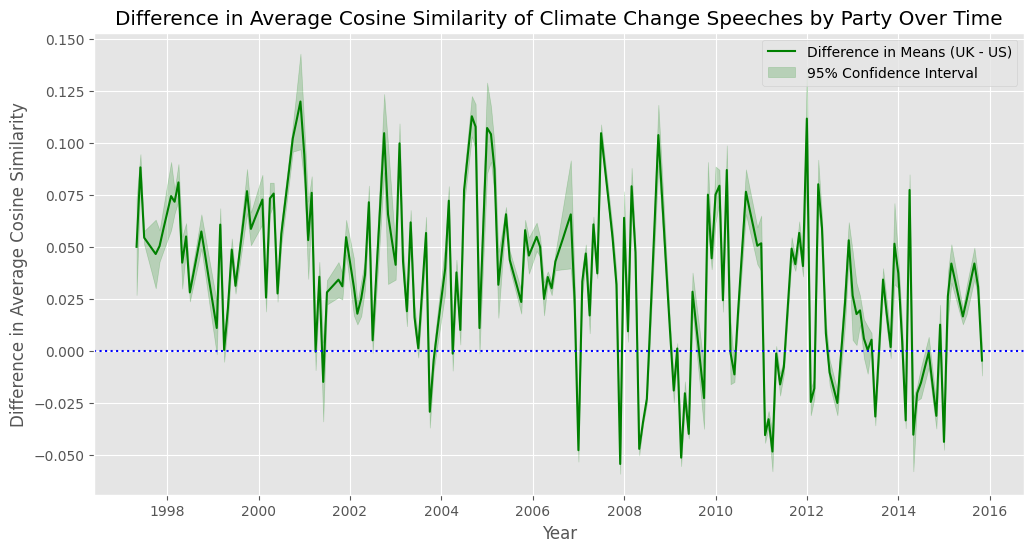

In [43]:
# Interpolate missing values for plotting
interpolated_climate_monthly_similarities = climate_monthly_similarities.interpolate(
    method='time').dropna()

plt.figure(figsize=(12, 6))
plt.plot(interpolated_climate_monthly_similarities.index.to_timestamp(
), interpolated_climate_monthly_similarities['difference_in_means'], label='Difference in Means (UK - US)', color='green')
plt.fill_between(interpolated_climate_monthly_similarities.index.to_timestamp(),
                 interpolated_climate_monthly_similarities['lower_bound_diff'],
                 interpolated_climate_monthly_similarities['upper_bound_diff'], color='green', alpha=0.2, label='95% Confidence Interval')
plt.axhline(0, color='blue', linestyle='dotted')
plt.title('Difference in Average Cosine Similarity of Climate Change Speeches by Party Over Time')
plt.xlabel('Year')
plt.ylabel('Difference in Average Cosine Similarity')
plt.legend()
plt.show()

**Climate embeddings statistics**


In [88]:
climate_monthly_similarities.dropna(inplace=True)

print(
    f'Total months with positive difference: {climate_monthly_similarities["significant_positive_diff"].sum()}')
print(
    f'Total months with negative difference: {climate_monthly_similarities["significant_negative_diff"].sum()}')
print(
    f'Total months with no difference: {len(climate_monthly_similarities) - climate_monthly_similarities["significant_positive_diff"].sum() - climate_monthly_similarities["significant_negative_diff"].sum()}')
print(f'Total months: {len(climate_monthly_similarities)}')

Total months with positive difference: 124
Total months with negative difference: 28
Total months with no difference: 18
Total months: 170


**Complete embeddings monthly average cosine similarities**


/var/folders/g4/5xzy77v17m1fbt0xq_sn3f140000gn/T/ipykernel_61105/1922909394.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  monthly_similarities = monthly_similarities.interpolate(


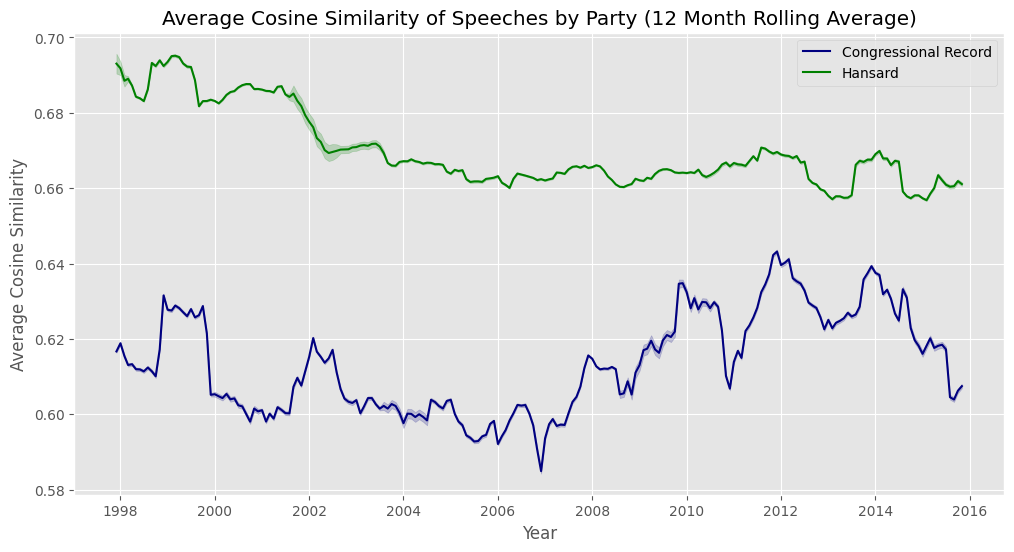

In [40]:
monthly_similarities = pd.read_csv(DATA_PATH + 'monthly_similarities.csv')
monthly_similarities.index = pd.PeriodIndex(
    monthly_similarities['year_month'], freq='M')

# Interpolate missing values for plotting
monthly_similarities = monthly_similarities.interpolate(
    method='time').dropna()

# Window for rolling average
widow = 12

plt.figure(figsize=(12, 6))
plt.plot(monthly_similarities.index.to_timestamp(), monthly_similarities['congressional_record_average_similarity'].rolling(
    window=widow).mean(), label='Congressional Record', color='navy')
plt.fill_between(monthly_similarities.index.to_timestamp(), monthly_similarities['congressional_record_lower_bound'].rolling(
    window=widow).mean(), monthly_similarities['congressional_record_upper_bound'].rolling(window=widow).mean(), alpha=0.2, color='navy')

plt.plot(monthly_similarities.index.to_timestamp(), monthly_similarities['hansard_average_similarity'].rolling(
    window=widow).mean(), label='Hansard', color='green')
plt.fill_between(monthly_similarities.index.to_timestamp(), monthly_similarities['hansard_lower_bound'].rolling(
    window=widow).mean(), monthly_similarities['hansard_upper_bound'].rolling(window=widow).mean(), alpha=0.2, color='green')

plt.title('Average Cosine Similarity of Speeches by Party (12 Month Rolling Average)')
plt.xlabel('Year')
plt.ylabel('Average Cosine Similarity')
plt.legend()

## Validation


In [126]:
climate_congressional_record_embeddings = pd.read_parquet(
    DATA_PATH + 'climate_congressional_record_embeddings.parquet')
climate_hansard_embeddings = pd.read_parquet(
    DATA_PATH + 'climate_hansard_embeddings.parquet')

climate_monthly_similarities = pd.read_parquet(
    DATA_PATH + 'climate_monthly_similarities.parquet')

climate_congressional_record_embeddings['year_month'] = pd.to_datetime(
    climate_congressional_record_embeddings['date']).dt.to_period('M')
climate_hansard_embeddings['year_month'] = pd.to_datetime(
    climate_hansard_embeddings['speech_date']).dt.to_period('M')

climate_congressional_record_embeddings.sort_values('date', inplace=True)
climate_hansard_embeddings.sort_values('speech_date', inplace=True)

### Investigating the most similar speeches in three randomly selected months of the Climate Congressional Record and Climate Hansard


**Functions**


In [118]:
def find_most_similar_speeches(group, party_1, party_2, speaker_column, date_column, text_column,  party_column):
    # Filter speeches by party
    party_1_group = group[group[party_column] == party_1]
    party_2_group = group[group[party_column] == party_2]

    if party_1_group.empty or party_2_group.empty:
        return pd.DataFrame()

    # Calculate cosine similarities between the speeches in the two groups
    similarity_matrix = cosine_similarity(
        party_1_group['weighted_embedding'].tolist(),
        party_2_group['weighted_embedding'].tolist()
    )

    # Find the indexes of the largest similarity scores
    max_similarity_indexes = np.unravel_index(
        np.argsort(similarity_matrix, axis=None)[-2:], similarity_matrix.shape)

    party_1_speech_indexes = party_1_group.index[max_similarity_indexes[0]].tolist(
    )
    party_2_speech_indexes = party_2_group.index[max_similarity_indexes[1]].tolist(
    )
    max_similarities = similarity_matrix[max_similarity_indexes]

    party_1_speeches = party_1_group.loc[party_1_speech_indexes]
    party_2_speeches = party_2_group.loc[party_2_speech_indexes]

    party_1_speeches.rename(columns={
        speaker_column: 'party_1_name',
        date_column: 'party_1_speech_date',
        text_column: 'party_1_text',
        party_column: 'party_1_party'
    }, inplace=True)
    party_2_speeches.rename(columns={
        speaker_column: 'party_2_name',
        date_column: 'party_2_speech_date',
        text_column: 'party_2_text',
        party_column: 'party_2_party'
    }, inplace=True)

    similar_speeches_df = pd.concat([
        party_1_speeches.reset_index(drop=True)[
            ['party_1_name', 'party_1_speech_date', 'party_1_text', 'party_1_party']],
        party_2_speeches.reset_index(drop=True)[
            ['party_2_name', 'party_2_speech_date', 'party_2_text', 'party_2_party']],
        pd.Series(max_similarities, name='similarity')
    ], axis=1).reset_index(drop=True)

    return similar_speeches_df

**Randomly selecting three months**


In [203]:
congressional_dates_with_speeches = climate_congressional_record_embeddings['year_month'].unique(
)
hansard_dates_with_speeches = climate_hansard_embeddings['year_month'].unique(
)

intersecting_dates_with_speeches = np.intersect1d(
    congressional_dates_with_speeches, hansard_dates_with_speeches)

# Randomly select 3 months from those that have speeches in both datasets
if len(intersecting_dates_with_speeches) > 0:
    random_dates = np.random.choice(
        intersecting_dates_with_speeches, 3, replace=False)

partitioned_climate_congressional_record_embeddings = climate_congressional_record_embeddings[
    climate_congressional_record_embeddings['year_month'].isin(random_dates)
]

partitioned_climate_hansard_embeddings = climate_hansard_embeddings[
    climate_hansard_embeddings['year_month'].isin(random_dates)
]

**Finding each month's most similar speeches**


In [207]:
similar_climate_congressional_record_speeches = partitioned_climate_congressional_record_embeddings.groupby(
    'year_month').progress_apply(
    lambda month_group: find_most_similar_speeches(
        month_group, 'R', 'D', 'speaker', 'date', 'speech', 'party')
)

similar_climate_hansard_speeches = partitioned_climate_hansard_embeddings.groupby(
    'year_month').progress_apply(
    lambda month_group: find_most_similar_speeches(
        month_group, 'Conservative', 'Labour', 'name', 'speech_date', 'text', 'speech_party')
)

similar_climate_congressional_record_speeches.to_csv(
    DIST_PATH + 'similar_climate_congressional_record_speeches.csv')

similar_climate_hansard_speeches.to_csv(
    DIST_PATH + 'similar_climate_hansard_speeches.csv')

100%|██████████| 3/3 [00:00<00:00, 29.38it/s]


### Investigating the two months of the Climate Congressional Record and Climate Hansard with the lowest average cosine similarities


**Functions**


In [127]:
def calculate_average_cosine_similarities(group, party_centroid, global_centroid):
    embeddings = np.vstack(group['weighted_embedding'])
    party_cosines = cosine_similarity(embeddings, party_centroid).flatten()
    global_cosines = cosine_similarity(embeddings, global_centroid).flatten()

    avg_party_cosine = np.mean(party_cosines)
    avg_global_cosine = np.mean(global_cosines)

    # Perform a paired t-test for the difference in means
    t_statistic, p_value = ttest_rel(party_cosines, global_cosines)

    return avg_party_cosine, avg_global_cosine, p_value


def party_versus_global_centroid_difference(group, party_1, party_2, party_column):
    # Filter speeches by party
    party_1_group = group[group[party_column] == party_1]
    party_2_group = group[group[party_column] == party_2]

    if party_1_group.empty or party_2_group.empty:
        return pd.Series({
            'party_1_to_party_centroid': np.nan,
            'party_2_to_party_centroid': np.nan,
            'party_1_to_global_centroid': np.nan,
            'party_2_to_global_centroid': np.nan
        })

    # Calculate the centroid of the speeches for each party
    party_1_centroid = np.mean(
        party_1_group['weighted_embedding'].tolist(), axis=0).reshape(1, -1)
    party_2_centroid = np.mean(
        party_2_group['weighted_embedding'].tolist(), axis=0).reshape(1, -1)

    # Calculate the month's global centroid
    global_centroid = np.mean(
        group['weighted_embedding'].tolist(), axis=0).reshape(1, -1)

    party_1_avg_party_cosine, party_1_avg_global_cosine, p_value_1 = calculate_average_cosine_similarities(
        party_1_group, party_1_centroid, global_centroid)
    party_2_avg_party_cosine, party_2_avg_global_cosine, p_value_2 = calculate_average_cosine_similarities(
        party_2_group, party_2_centroid, global_centroid)

    return pd.Series({
        f'{party_1}_to_party_centroid': party_1_avg_party_cosine,
        f'{party_1}_to_global_centroid': party_1_avg_global_cosine,
        f'{party_1}_difference': party_1_avg_party_cosine - party_1_avg_global_cosine,
        f'{party_1}_p_value': p_value_1,
        f'{party_1}_num_speeches': party_1_group.shape[0],
        f'{party_2}_to_party_centroid': party_2_avg_party_cosine,
        f'{party_2}_to_global_centroid': party_2_avg_global_cosine,
        f'{party_2}_difference': party_2_avg_party_cosine - party_2_avg_global_cosine,
        f'{party_2}_p_value': p_value_2,
        f'{party_2}_num_speeches': party_2_group.shape[0]
    })

**Fetching the two months with the lowest average cosine similarities in the Climate Congressional Record and Climate Hansard**


In [136]:
climate_monthly_similarities.dropna(inplace=True)

dissimilar_congressional_record_months = climate_monthly_similarities.nsmallest(
    5, 'climate_congressional_record_average_similarity').index

dissimilar_climate_congressional_record_embeddings = climate_congressional_record_embeddings[
    climate_congressional_record_embeddings['year_month'].isin(
        dissimilar_congressional_record_months)
]

dissimilar_hansard_months = climate_monthly_similarities.nsmallest(
    5, 'climate_hansard_average_similarity').index

dissimilar_climate_hansard_embeddings = climate_hansard_embeddings[
    climate_hansard_embeddings['year_month'].isin(dissimilar_hansard_months)
]

**Investigating the two lowest average cosine similarity months in the Climate Congressional Record**


In [137]:
congressional_record_party_versus_global_distances = dissimilar_climate_congressional_record_embeddings.groupby(
    'year_month').apply(
    lambda month_group: party_versus_global_centroid_difference(
        month_group, 'R', 'D', 'party')
)
congressional_record_party_versus_global_distances.to_csv(
    DIST_PATH + 'climate_congressional_record_party_versus_global_distances.csv')

hansard_party_versus_global_distances = dissimilar_climate_hansard_embeddings.groupby(
    'year_month').apply(
    lambda month_group: party_versus_global_centroid_difference(
        month_group, 'Conservative', 'Labour', 'speech_party')
)
hansard_party_versus_global_distances.to_csv(
    DIST_PATH + 'climate_hansard_party_versus_global_distances.csv')